# The problem from a business side

We aim to optimize the success rate. From a business perspective, we have the following options:

**A)** From a pool of potential clients, we could chose those with the highest success rates and call them first. The model should be able to rank clients in terms of 
probability.

**B)** For a give customer, we could aim to influence the controlled variables like month, day-of-week of the call, means of contact in an attempt to influence the call outcome - assuming, causality. The model should be able to give real-time, bespoke recommendations for actions that pull the sales process for each client towards a higher success probability. I.e. adressing whom, when and how to call.

# Chosing an evaluation metric and model

The model should
- have a high performance and generalize well -> don´t overfit
- be interpretable -> no neural networks
- lead to actionable insights
- be robust and be able to deal with missing values, outliers etc. -> This can be implemented in the inference pipeline, however, there are also models which handle it well, like XGBoost.

Compared of the cost of missing a potential client (false negative) the cost of an unsuccessful call is fairly low (false positives). Therefore, **we should optimize the classifier for recall**, i.e. keeping false negatives - or the number of uncalled clients that would have been successful - low.  

# Loading data
Lets load the preprocessed training and test data: See script "EDA & Preprocessing.ipynb" for details.
The features are already preprocessed, i.e. one-hot encoded, mapped or imputed. Both files also contain the engineered variable "month".

In [1]:
import pandas as pd

X_train = pd.read_csv('data/preprocessed_data/imputed_data.csv')
X_test = pd.read_csv('data/preprocessed_data/imputed_test_data.csv')

y_train = X_train["y"]
X_train = X_train.drop('y', axis=1) # drop target from the training data


# Establishing a baseline
How well does the model perform in terms of accuracy against random guessing or in this case, predicting only class y="no"?


In [2]:
percentage = (1 - sum(y_train) / len(y_train))  * 100
print(f'Baseline prediction accuracy is {percentage:.2f}%.')

Baseline prediction accuracy is 88.74%.


## Model Selection: Trying out a bunch of diverse tree-, regression ensemble based models

Due to the low cost of training, we can easily try out a bunch of models:

- **Logistic Regression**: Models the relationship linearly between the input features and the probability of belonging to a class using a logistic function. Feature scaling is beneficial!
- **Support Vector Machine**: Aims to find the best hyperplane that separates data by maximising distances. Feature importance is not directly interpretable. Feature scaling is beneficial!
- **Decision Tree**: Repeatedly plits data into sub-branches by maximizing information gain. Its highly interpretable and can be drawn.
- **Random Forest**: Combines decision trees but only considers a subset of features for each tree. It performs well with noisy data, can hanlde imbalanced data, is robust against overfitting and interpretable. 
- **Gradient Boosting Classifier**: Combines decision trees but in a sequential manner, correcting the errors of the previous tree. Advantages are similar to random forests but it tends to be more accurate, however, hyperparameter tuning is more complex.

Others that are not used: 
- K-Nearest Neighbors Classifier - I tried to cluster using k-Means in EDA but was unsuccessful.
- **XGBoost** - most promising algorithm, but very involved hyperparameter tuning.

As an educated guess, I tend towards tree-based algorithms: They are robust against overfitting, most interpretable and can handle errors in feature encoding, for example in case the order in ordinal features is not right ("education").

### Training strategy
- **5-fold Stratified Cross Validation**, in order to keep the class imbalance equal among the folds.
- **Metrics**: 'Accuracy', 'Precision', 'Recall', 'F1 Score' and 'AUC'.

### Training without any hyperparamter optimization to get a first glance
Without any hyperparameter optimization, most models achieve a similar performance around 90% with default Sklearn settings. The decision tree and the support vector classifier achieve around 88%-89% accuracy. Random Forest and Gradient Boosting achieves the top score >90% accuracy. 

### Hyperparamter optimization
Hyperparameter optimization was done via Grid Search in the script "Hyperparameter Tuning using Grid Search". There are more efficient ways like randomized search or even search space optimization.

### Training results
Gradient Boosting achieves almost 91% top accuracy and outperforms the other classifiers in all relevant metrics. Most importantly, the rate of recall is by far the highest. 
The decision tree has the highest precision which is not optimized for.


In [3]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

# Definition of models including best performing hyperparameters.
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier(max_depth = 40, min_samples_split = 20, n_estimators = 100)),
    ('Support Vector Machine', SVC()), # did not yet look for the best hyperparameter options.
    ('Decision Tree', DecisionTreeClassifier(criterion="gini", max_depth= 5, min_samples_leaf=1, min_samples_split= 100)),
    ('Gradient Boosting Classifier', GradientBoostingClassifier(learning_rate= 0.05, max_depth= 4, n_estimators= 500))
]

/Users/moritz.berthold/miniconda3/envs/daiichi/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import warnings
warnings.filterwarnings('ignore') # ignoring pandas warnings.

results = []
names = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Create a table to store evaluation metrics
metrics_table = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', "Std"])

for name, model in models:
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['precision', 'recall', 'f1', 'accuracy', 'roc_auc'])
    results.append(cv_results)
    names.append(type(model).__name__)
    print(f"{name}: Mean accuracy: {np.mean(cv_results['test_accuracy']*100):.2f}%, Standard deviation: {np.std(cv_results['test_accuracy']):.4f}")
    
    # Store evaluation metrics in the table
    metrics_table = metrics_table.append({
        'Model': name,
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'Precision': np.mean(cv_results['test_precision']),
        'Recall': np.mean(cv_results['test_recall']),
        'F1 Score': np.mean(cv_results['test_f1']),
        'AUC': np.mean(cv_results['test_roc_auc']),
        "Std" : np.std(cv_results['test_accuracy'])
    }, ignore_index=True)
    
metrics_table

Logistic Regression: Mean accuracy: 90.36%, Standard deviation: 0.0015
Random Forest: Mean accuracy: 90.65%, Standard deviation: 0.0012
Support Vector Machine: Mean accuracy: 89.32%, Standard deviation: 0.0020
Decision Tree: Mean accuracy: 90.55%, Standard deviation: 0.0016
Gradient Boosting Classifier: Mean accuracy: 90.82%, Standard deviation: 0.0010


,Model,Accuracy,Precision,Recall,F1 Score,AUC,Std
0,Logistic Regression,0.903586,0.640239,0.328576,0.434119,0.901090,0.001548
1,Random Forest,0.906472,0.666740,0.339366,0.449532,0.923183,0.001163
2,Support Vector Machine,0.893194,0.584638,0.177233,0.271890,0.825844,0.002043
3,Decision Tree,0.905500,0.649650,0.350148,0.454903,0.862719,0.001605
4,Gradient Boosting Classifier,0.908204,0.633366,0.440259,0.519105,0.928047,0.001014


# Feature importances
It is possible to measure the information gained when a variable is used to split data into y=0/1 during the training process of tree-based algorithms. Lets use it to get a feeling for the predictive importance of each variable.

### Results
Most features are fairly unimportant and add to noise. The top ranking features which show some distinct importance by order are: "duration", "p_outcome_success", "month", "age" , "season", "contact" and "previous". The added value of the engineered "season" is visible, however, many algorithms would be able to learn the feature as well.
The importance of all one-hot encoded features should be accumulated as for "job" - whose importance is quite low.

### Discussion
As already discovered in EDA, the nature of the interaction ("month", "duration" and "contact") seems to matter, as well as "age" and if the previous interaction has been successful. 

Total Importance of Job Features: 0.021


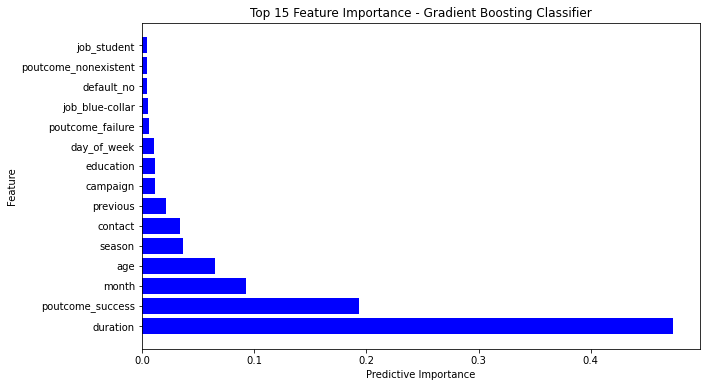

In [5]:
import matplotlib.pyplot as plt

# Train the gradient boosting classifier. The model can be exported since it is trained on the entire dataset.
final_model = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 4, n_estimators= 500)
final_model.fit(X_train, y_train)

# Get the feature importances
importance = final_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance in descending order
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_15_features = df_importance.head(15)

# Filter the features that start with "job_"
job_features = df_importance[df_importance['Feature'].str.startswith('job_')]
# Calculate the total importance of job features
total_job_importance = job_features['Importance'].sum()
print(f"Total Importance of Job Features: {total_job_importance:.3f}")

# Plot the feature importance table for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'], color='blue')
plt.xlabel('Predictive Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance - Gradient Boosting Classifier')
plt.show()

# Model Characteristics
Lets plot some model characteristics to get a feeling for the confusion matrix and receiver operating characteristics.

NameError: name 'labels' is not defined

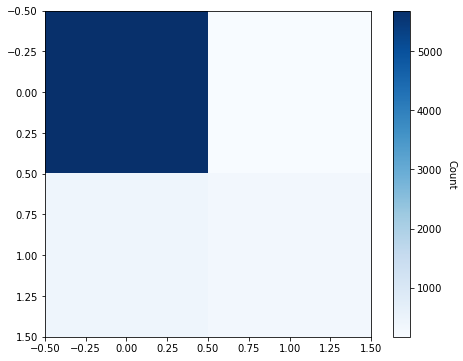

In [6]:
# Shuffle the data
from sklearn.utils import shuffle

# Shuffle the data
shuffled_X_train, shuffled_y_train = shuffle(X_train, y_train, random_state=42)

# Split the shuffled data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(shuffled_X_train, shuffled_y_train,
                                                              test_size=0.2, random_state=42)

# Train the Gradient Boosting Classifier on 90% of the shuffled X_train data
model = GradientBoostingClassifier()
model.fit(X_train_split, y_train_split)

# Predict probabilities for the validation set
probs = model.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, probs)
auc = roc_auc_score(y_val, probs)

# Calculate the absolute confusion matrix

# Predict the labels for the validation set
pred_labels = model.predict(X_val)
abs_cm = confusion_matrix(y_val, pred_labels)

# Calculate the relative confusion matrix as percentages of the total
rel_cm = abs_cm / abs_cm.sum() * 100

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Plot absolute confusion matrix with color bar
im = ax.imshow(abs_cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=-90, va='bottom')

# Plot relative confusion matrix as text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, "{:.2f}%\n{:d}".format(rel_cm[i, j], abs_cm[i, j]),
                       ha='center', va='center', color='black')

# Set x/y axis labels and tick labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Set labels and title
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Show plot
plt.tight_layout()
plt.show()

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Predicting on the test set
Predicting and storing predictions. Out of 40 samples, 3 are predicet as y="yes".

In [ ]:
y_pred = final_model.predict(X_test)
probs = final_model.predict_proba(X_test)[:,1]
X_out = X_test.copy()
X_out["y"] = y_pred
X_out["y"] = X_out["y"].map({0: "no", 1: "yes"})
X_out["prob. y=1"] = probs
X_out.to_csv('data/predictions/test_data_predicted.csv', index=False)

In [ ]:
X_test[X_test.y=="yes"]

# Next Steps
In alignment with business objectives, the model should be further tuned to optimize the recall and sensititvity: The options are:
- Setting class weights
- setting appropriate thresholds at inference time
- using oversampling or undersampling